# Sniffing out Democrats and Republicans around Reddit

### Table of Contents
#### Notebook 1: Establishing basic model
* Ground Rules and assumptions
* Package imports
* Get base data to fit model guesser
* Create custom functions used to simplify process
* fit model and establish transformation 
* Basic Data Summary statistics
* Visualizing the Data
#### Notebook 2: Evaluating Random subreddits
* Ground Rules and assumptions
* Package imports
* Get base data to fit model guesser
* Create custom functions used to simplify process
* fit model and establish transformation (everything is the same up to here)
* Evaluate subreddits for political sentiment

## Ground Rules and Assumptions
1. Post titles accurately summarize discussions
2. Distribution of topics in recent posts is the same as that in popular
3. Party word predictors are constant over time
4. Low sarcasm level in the base sets
5. When working with 3 classes:   
  0 Class == Neither, 1 Class == Republican, 2 Class == Democrat   
 When working with 2 classes:
  0 Class == Republican, 1 Class == Democrat

In [2]:
import pandas as pd
import numpy as np
import scipy as sp

import requests
import json
import time

from random import randint
from math import exp

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

from sklearn.feature_extraction import stop_words
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.metrics import confusion_matrix

from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [3]:
#Something to consider: This estimate of prior probability uses the relative number of subscribers for /r/Democrat and /r/Republican to estimate reddit
#Figures as of 8/30/2018
dem_subscribers = 66.2 #Thousand
reb_subscribers = 52.4 #Thousand
dem_prior = dem_subscribers / (dem_subscribers + reb_subscribers)
rep_prior = 1 - dem_prior
dem_prior 

0.5581787521079259

## Initial Pull (needed for fit_transform function default inputs)
As part of the model development process, two sets of requests from /r/democrats and /r/Republican were pulled down on 8.31 and 9.03 to be static basepoints. These are preserved at the top of this notebook as a baseline. It may be advisable to go back and update this later to avoid news topics from that week. This will presumably entail additional calibration of systematic error.

In the first attempt to run this model, it became apparent that having only 2 classes created a lot of false positive words. Apparently, reddit communities discuss similar things. Therefore, a third null class was added to catch all the reddit-y words not overwise eliminated in the stop words. This consists of the following popular subs:
* All
* dogs
* cats
* humansbeingbros

Later, we will be able to more decisively compare democrat estimates and republican estiamtes, instead of NOT democrat and democrat.

Fun Fact: /r/Democrat, what you would expect to be the counterpar of /r/Republican, is apparently entirely overrun with trolls. It is not advisable to visit this page, whatever your political leanings. 

In [4]:
#Read in democrat and republican baseline data
df_dems_1 = pd.read_csv('./Data/InitialDemocratsPosts_8_31.csv')
df_dems_2 = pd.read_csv('./Data/InitialDemocratsPosts_9_03.csv')

'''One post (stickied at the top) was locked and showed up in both hits on r/dem. 
Removed it since our model is about number of posts, not strength or relevancy of those posts.'''
df_democrats_all = df_dems_1.append(df_dems_2.iloc[1:, ], ignore_index=True)

df_reps_1 = pd.read_csv('./Data/InitialRepublicanPosts.csv')
df_reps_2 = pd.read_csv('./Data/InitialRepublicanPosts_9_03.csv')
df_republicans_all = df_reps_1.append(df_reps_2, ignore_index=True)

#Null group sets
df_all_init = pd.read_csv('./Data/allPosts_9_04_A.csv')
df_cats_init = pd.read_csv('./Data/catsPosts_9_03_A.csv')
df_dogs_init = pd.read_csv('./Data/dogsPosts_9_03_A.csv')
df_hbb_init = pd.read_csv('./Data/hbbPosts_9_04_A.csv')

#Join all to single dataframe
df_init_DemRep = df_democrats_all.append(df_republicans_all, ignore_index=True, verify_integrity=True)
for df in [df_all_init,df_cats_init, df_dogs_init, df_hbb_init]:
    df_init_DemRep =  df_init_DemRep.append(df, ignore_index=True, verify_integrity=True)
    
#confirm 4004 posts included
print('    Data Shape: ',df_init_DemRep.shape) 
print('    Duplicate headers (expect count 2): ', len([label for label in df_init_DemRep['subreddit'].value_counts().index if label =='democrats' or label =='Republican']))  #Expect 2

#Translate to 0, 1, 2 groups
df_init_DemRep['subred_cat'] = (df_init_DemRep['subreddit']=='democrats')*2 + (df_init_DemRep['subreddit']=='Republican')*1
df_init_DemRep.fillna(' ', inplace=True)
print('    nulls: ', df_init_DemRep.isnull().sum())
print('    new counts: ', df_init_DemRep['subred_cat'].value_counts())

    Data Shape:  (4004, 3)
    Duplicate headers (expect count 2):  2
    nulls:  selftext      0
subreddit     0
title         0
subred_cat    0
dtype: int64
    new counts:  0    2003
2    1001
1    1000
Name: subred_cat, dtype: int64


## Custom Functions

#### Fit Transform
This function works very similar to pipeline, with some added outputs. A base vectorization is chosen with associated transform. It is then fit against a chosen model.   
  
The results of this process are output via global variable exports.   
This function also links features and predict probas for each class and stores dictionary versions for global. 

In [5]:
my_stop_words = stop_words.ENGLISH_STOP_WORDS
#no compelling reason to pull in self-text
df_data = df_init_DemRep.loc[:, ['subred_cat', 'title']]
def fit_transform_model(X=df_data.title, y=df_data.subred_cat, 
                        vecmod='TFID', pred='logreg', 
                        test_size_local=None, random_state_local=42 ):
    """
    X data pre-transform, y data classes.
    vecmod - some vectorizer. Default is TF-ID. Must put fully instatiated vectorizer in here to update
    pred - predictor. default is logisticregression
    test_size_local - split size for train test split
    random_state for train test split
    """
    
    #get vectorizer
    if vecmod == 'TFID':
        vecmod_ = TfidfVectorizer(stop_words=my_stop_words, ngram_range=(1,3))
    else:
        vecmod_ = vecmod
    
    #TTS, fit transform on x_train, convert back to pd.DataFrame for later feature extraction
    X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                        test_size=test_size_local, 
                                                        random_state=random_state_local)
    X_train_transform = vecmod_.fit_transform(X_train).todense()
    df_X_train_transform = pd.DataFrame(X_train_transform, columns=vecmod_.get_feature_names())
    X_test_transform = vecmod_.transform(X_test).todense()
    df_X_test_transform = pd.DataFrame(X_test_transform, columns=vecmod_.get_feature_names())
    
    #predict model
    if pred == 'logreg':
        funct_model_= LogisticRegression()
    else:
        funct_model_ = pred
        
    funct_model_.fit(df_X_train_transform, y_train)
    
    #Export features and scores
    global latest_model, latest_transform, sorted_d_values_none, sorted_d_values_rep, sorted_d_values_dem, train_x, test_x, test_y, train_y
    latest_model = funct_model_ 
    train_x, test_x, train_y, test_y = df_X_train_transform, df_X_test_transform, y_train, y_test
    latest_transform = vecmod_
    
    try:
        #create feature dictionaries of each word for each category. only sorted_d is exported 
        feature_values_none =(dict(zip(list(df_X_train_transform.columns), list(funct_model_.coef_[0]))))
        sorted_d_values_none = sorted({(value, key) for (key,value) in feature_values_none.items()}, reverse=True)
        
        feature_values_rep =(dict(zip(list(df_X_train_transform.columns), list(funct_model_.coef_[1]))))
        sorted_d_values_rep = sorted({(value, key) for (key,value) in feature_values_rep.items()}, reverse=True)
        
        feature_values_dem =(dict(zip(list(df_X_train_transform.columns), list(funct_model_.coef_[2]))))
        sorted_d_values_dem = sorted({(value, key) for (key,value) in feature_values_dem.items()}, reverse=True)

    except:
        print('   broken sorter')
        return funct_model_.score(df_X_test_transform, y_test)
    
    return funct_model_.score(df_X_test_transform, y_test)

#### Get New Data
This function is meant to consolidate the repeated steps of grabbing basic info from subreddit pages, then condensing it to a single DataFrame.
Only subreddit and post title information is pulled for simplicity.     
At the end, prints randomly generated title for future referencing and globally stores data frame as df_lastest_scrape.  
Also prints shape to verify number of records.  

Caution:
1. Save function assumes Data subfolder exists in working directory.  
2. max_pulls defaults to 40 requests to reddit, with 3 second pauses to avoid being blocked. can take 2 minutes to run, and csv is not saved in the interim. 


In [6]:
def subreddit_getter(subreddit_source, your_name_bot, max_pulls=40):
    """Subreddit source is the sub to be pulled from. should be literal string. E.G., /r/football should be input as 'football'
    your_name_bot will be used to associate calls on your machine.
    max_pulls is number of times to query subreddit data
    
    The resulting dataframe from this process is available globally as df_latest_scrape after completion. 
    
    NB: Save function assumes Data subfolder exists in working directory.
    """
    data_list = []
    base_url = "https://www.reddit.com/r/" + subreddit_source + "/.json"
    URL = base_url

    #seems to be a cap around 20 for some smaller subs
    for _ in range(max_pulls):
        try:
            data = requests.get(URL, headers={'User-agent': your_name_bot}).json()

            for i in range(len(data['data']['children'])):
                temp = {}
                temp['subreddit'] = data['data']['children'][i]['data']['subreddit_name_prefixed'].replace('r/', '')
                temp['title']=data['data']['children'][i]['data']['title']
                data_list.append(temp)

            new_after = data['data']['after']
            URL = base_url + "?after=" + new_after
            print('    iteration {} worked. URL: {}'.format(step, URL))
                
            time.sleep(3)  #very important to avoid getting locked out by Reddit.
        except: 
            break
    #Create dataframe, write to csv, save to notebook
    df_scrape = pd.DataFrame(data_list)
    random_name = subreddit_source + str(randint(1, 100000)) #Randint used to avoid writing over previous csvs
    df_scrape.to_csv('./Data/' + random_name + '.csv')
    
    global df_latest_scrape
    df_latest_scrape = df_scrape
    
    print('    text file: ', random_name)
    print('    data frame size: ', df_scrape.shape)

#### Subreddit Analyzer
After the model has been fit, we next want to look at a particular subreddit to see if it is more republican or democrat. 

Given the nature of the training data, the model will more than likely just predict neither. However, every post will score somewhere on the Democcratic and Republican scale. 

In [56]:
def subreddit_Analysis(df_data_current_, output_figname=None, bump_dems=True):
    """
    df_data_current is an untransformed dataframe of post titles, with 2 columns: subreddit, and title
    output_figname: if none (default), do not output and save score distribution. otherwise, use name provided. 
    output_figname assumes that there is a subfolder in current working directory:  ./Presentation/Outputfigs/
    bump_dems: if True (default), include systematic adjustment for democratic posts
    """
    #Jump into analysis for this subreddit here from here
    
    X_cur = latest_transform.transform(df_data_current_.title).todense()
    df_cur_predictions = pd.DataFrame(latest_model.predict(X_cur), columns=['Party'])

    df_cur_predictions = df_cur_predictions.join(pd.DataFrame(latest_model.predict_proba(X_cur), columns = ['none_score','rep_score', 'dem_score'] ))
    
    
    '''
    Systematic adjustment for built in model bias. Necessary for intercept tuning in the wild. 
    See discussion: How strong are the resulting proba scores for each post? below
    Arrived at .45 adjustment after calibration. Otherwise, simulates setting intercepts equal to 
    eachother in predicted probas calculation.
    '''
    if bump_dems:
        dem_bump = abs(exp(latest_model.intercept_[2])-exp(latest_model.intercept_[1]))*.45
    else:
        dem_bump = 0
    df_cur_predictions['dem_score'] = df_cur_predictions['dem_score'] + dem_bump
    

    #Number of posts identified in each class
    print('   Initial None Count: ', len(df_cur_predictions[df_cur_predictions.Party == 0]))
    print('   Initial Rep Count: ', len(df_cur_predictions[df_cur_predictions.Party == 1]))
    print('   Initial Dem Count: ', len(df_cur_predictions[df_cur_predictions.Party == 2]))
    print('    Some of initial dem and rep count gives a sense of inherent political-ness of subreddit')
    
    #In this section, we force the model to pick dem or rep for every post. Then we rescore it, and output a nice figure that visualizes the spread 
    '''The next 3 rows mimic the output of a 2 category model with type republican =0, democrat=1. 
    Since we are asking, what is the dominant party ranking for this sub, other than none, we want some intentionally biased results.'''
    df_cur_predictions['NewDem'] = 1*(df_cur_predictions['dem_score'] > df_cur_predictions['rep_score']) #Score whichever is higher proba
    #create 'Normalized' probabs based on the assumption that a post is either republican or democrat and never neither 
    df_cur_predictions['NewDem_proba'] = df_cur_predictions['dem_score']/(df_cur_predictions['dem_score']+df_cur_predictions['rep_score'])
    df_cur_predictions['NewRep_proba'] = 1 - df_cur_predictions['NewDem_proba']
    #Counts after normalization
    print('   New Dem Count: ', df_cur_predictions['NewDem'].sum())
    print('   New Rep Count: ', df_cur_predictions['NewDem'].count() - df_cur_predictions['NewDem'].sum())
    #Avg aggregate rating - >.5 indicates dem
    print('   New Percent Dem: ', df_cur_predictions['NewDem'].mean())

    #summarize winning scores for each party 
    probas = df_cur_predictions.loc[:, ['NewDem_proba', 'NewRep_proba']]
    min_prob = .5
    dem_probs = []
    rep_probs = []
    for i in range(len(probas)):
        if probas.iloc[i][1] >min_prob:
            rep_probs.append(probas.iloc[i][1])
        elif probas.iloc[i][0]>min_prob:
            dem_probs.append(probas.iloc[i][0])

    net_probs = []
    for i in range(len(probas)):
        net_probs.append(probas.iloc[i][1] - probas.iloc[i][0]) #R minus D so that Republican == positive, 

    print('   net sum of probas: ', sum(net_probs))
    print('   mode: ', sp.stats.mode(net_probs)) #Handy detector for systematic error, apparently

    #Color graph based on whether democrats or republicans dominate the subreddit
    if df_cur_predictions['NewDem'].mean() > .5: 
        wincolor = 'blue'
    else:
        wincolor = 'red'
    sns.distplot(net_probs, label='rep', color=wincolor)
    
    if output_figname is not None:
        plt.savefig('./Presentation/OutputFigs/' + output_figname + '.png')

## Model Assessment
---

In [8]:
fit_transform_model(test_size_local=.2)

0.8014981273408239

In [9]:
print('   none indicators:')
for i in range(10):
    print('    ', sorted_d_values_none[i])
#print('    democratic indicators: ', sorted_d[:-10])
print('\n    rep indicators:')
for i in range(10):
    print('    ', sorted_d_values_rep[i])
print('\n    dem indicators:')
for i in range(10):
    print('    ', sorted_d_values_dem[i])

   none indicators:
     (5.611738448785891, 'help')
     (3.9711631418586015, 'dog')
     (3.127261765291027, 'cat')
     (2.57944795429636, 'discussion')
     (1.876685001273597, 'dogs')
     (1.811047702858205, 'breeds')
     (1.5562430995005374, 'breed')
     (1.4505424076744973, 'little')
     (1.4223197142199957, 'old')
     (1.3140248902515075, 'love')

    rep indicators:
     (1.8117442133225576, 'liberals')
     (1.6367265811688123, 'senate')
     (1.585471302796486, 'walkaway')
     (1.3890949271144213, 'hc')
     (1.3869125345202595, 'brennan')
     (1.3669681607886188, 'media')
     (1.3397263388347898, 'republican')
     (1.3317468293628683, 'left')
     (1.3179722493103019, 'socialism')
     (1.2137656494541853, 'gop')

    dem indicators:
     (7.177275355534448, 'trump')
     (3.4461724377327134, 'president')
     (2.993538142074914, 'mccain')
     (2.5007589979018023, 'kavanaugh')
     (2.459963898494526, 'twitter')
     (2.3702938426215443, 'republicans')
     (2.236

In [10]:
cm = confusion_matrix(test_y, latest_model.predict(test_x))
df_cm = pd.DataFrame(cm, columns=['Predicted None', 'Pred Rep', 'Pred Dem'], index=['Actual None', 'Actual Rep', 'Actual Dem'])
df_cm

,Predicted None,Pred Rep,Pred Dem
Actual None,373,2,2
Actual Rep,86,108,18
Actual Dem,43,8,161


# Baseline Data Set Meta Analysis
---

## Word Cloud

In [11]:
#!pip install wordcloud

In [12]:
#https://www.geeksforgeeks.org/generating-word-cloud-python/

In [13]:
from wordcloud import WordCloud

In [14]:
none_word_dict = dict(sorted_d_values_none[:50])
rep_word_dict = dict(sorted_d_values_rep[:50])
dem_word_dict = dict(sorted(sorted_d_values_dem[:50]))

In [15]:
from math import exp
import random

In [16]:
rep_word_dict_trans = {}
for key in rep_word_dict.keys():
    new_key_= int(exp(-key)*2000) #watch out for this negative
    while new_key_ in rep_word_dict.keys():
        new_key_+=1 #tie breaker prevents override of values
        print('    ',new_key_)
    rep_word_dict_trans[new_key_] = rep_word_dict[key]
rep_words_str = ''
for key in rep_word_dict_trans.keys():
    rep_words_str = rep_words_str + key*(str(rep_word_dict_trans[key]) + ' ')

In [17]:
dem_word_dict_trans = {}
for key in dem_word_dict.keys():
    new_key_= int(exp(key)*2000)
    while new_key_ in dem_word_dict.keys():
        new_key_+=1
        print('    ',new_key_)
    dem_word_dict_trans[new_key_] = dem_word_dict[key]
dem_words_str = ''
for key in dem_word_dict_trans.keys():
    dem_words_str = dem_words_str + key*(str(dem_word_dict_trans[key]) + ' ')
#dem_word_dict_trans

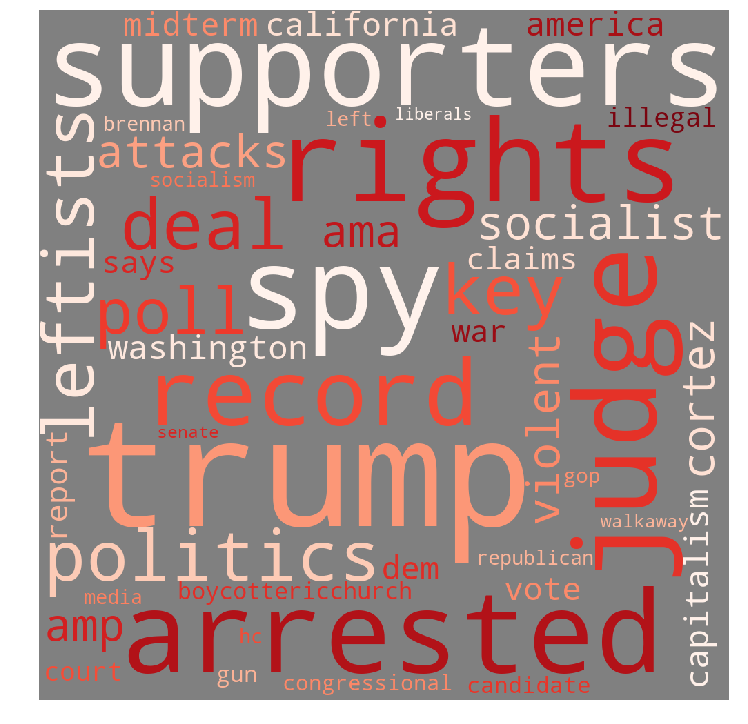

In [71]:
mycloud = WordCloud(width=1000, height=1000,
                    background_color='grey', 
                    colormap='Reds',
                    min_font_size=1,
                    max_words=len(rep_words_str),
                    collocations=False, #get rid of duplicates
                   normalize_plurals=False).generate_from_text(rep_words_str)
plt.figure(figsize = (10, 10), facecolor = None)
plt.imshow(mycloud)
plt.axis("off")
plt.tight_layout(pad = 0)
mycloud.to_file('./Presentation/OutputFigs/RepCloud_3.png')

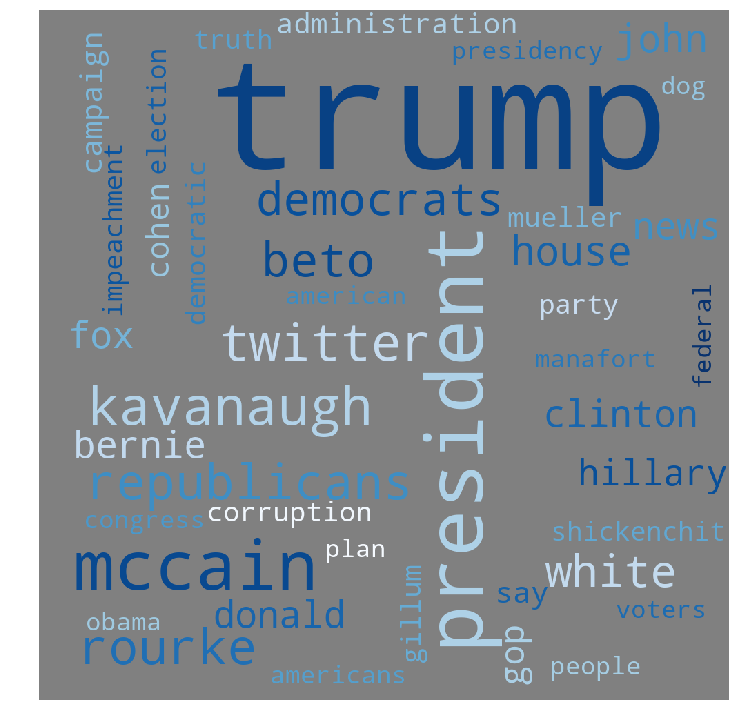

In [18]:
mycloud = WordCloud(width=1000, height=1000,
                    background_color='grey', 
                    min_font_size=1,
                    colormap='Blues',
                    collocations=False, #get rid of duplicates
                   normalize_plurals=False,
                   max_words=len(dem_words_str)).generate_from_text(dem_words_str)
plt.figure(figsize = (10, 10), facecolor = None)
plt.imshow(mycloud)
plt.axis("off")
plt.tight_layout(pad = 0)
mycloud.to_file('./Presentation/OutputFigs/DemCloud_3.png')

## Word Clustering Analysis - why are scores happening?

In [ ]:
#Talk about overlap - words more tightly clustered for republican/

In [75]:
latest_model.intercept_ #Democrat intercept is more penalizing - why?

array([ 0.2303148 , -1.2202583 , -1.43678538])

In [20]:
#Total Identified words:
len(test_x.columns)

40093

### What is the distribution of Positive Identifiers for each party?

#### How many words are above a given 'strength' score for dems vs. republicans

In [ ]:
#Get lists for positive identifiers only, along with their coefficients
all_rep_words = { key:dict(sorted_d_values_rep)[key] for key in dict(sorted_d_values_rep).keys() if key>0 }
all_dem_words = { key:dict(sorted_d_values_dem)[key] for key in dict(sorted_d_values_dem).keys() if key>0 }
print('   Positive Democratic Words:', len(all_dem_words))
print('   Positive Republican Words:', len(all_rep_words))
print('   ', len(all_rep_words)+len(all_dem_words))

In [24]:
max(all_dem_words.keys())

7.177275355534448

In [25]:
results_list = []
for i in range(4,500, 10):
    j = i/100
    temp_dict = {}
    temp_dict['strength'] = j
    temp_dict['dem_words'] = len([key for key in dict(sorted_d_values_dem).keys() if key>j])
    temp_dict['rep_words'] = len([key for key in dict(sorted_d_values_rep).keys() if key>j])
    results_list.append(temp_dict)

,dem_words,rep_words,strength
0,2021,1673,0.04
1,1189,1168,0.14
2,574,634,0.24
3,334,364,0.34
4,208,204,0.44
5,139,115,0.54
6,96,73,0.64
7,70,45,0.74


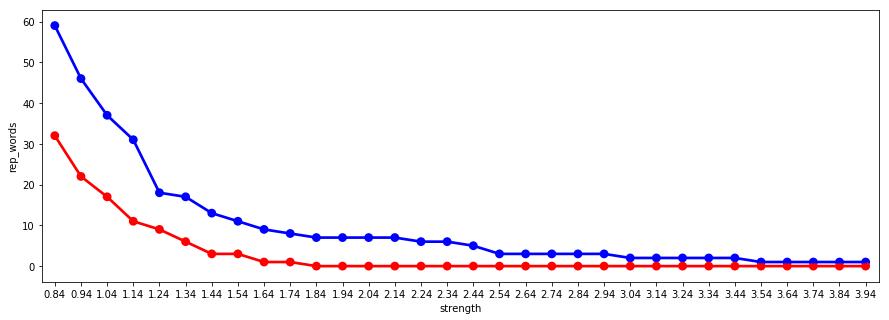

In [42]:
#Let's look at the tails on these positive indicators
df_stregnths = pd.DataFrame(results_list)
df_stregnths = df_stregnths[(df_stregnths['strength']>.8) & (df_stregnths['strength']<4)]
fig, ax2 = plt.subplots(figsize=(15,5))
sns.pointplot('strength','dem_words', data=df_stregnths, color='b', ax=ax2)
sns.pointplot('strength','rep_words', data=df_stregnths, color='r', ax=ax2)

Answer: It looks like Democrats has more words with very high strength scores.  
The intercept on Dems is likely penalizing these.

#### How strong are the resulting proba scores for each post?

    average dem score:  0.26338961507134206
    average rep score:  0.24336653846695983


C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


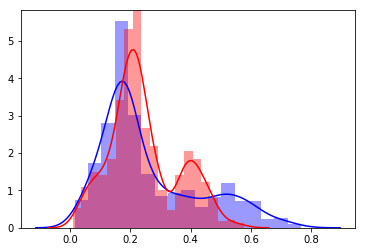

In [47]:
#compare predict probas
probas = latest_model.predict_proba(test_x)
dem_probs = []
rep_probs = []
for i in range(len(probas)):
    rep_probs.append(probas[i][1])
    dem_probs.append(probas[i][2])
print('    average dem score: ', sum(dem_probs) / len(dem_probs))
print('    average rep score: ', sum(rep_probs) / len(rep_probs))
#Distribution of republican and Democrat strength scoring
sns.distplot(dem_probs, label='dem', color='blue') 
sns.distplot(rep_probs, label='rep', color='red')

Answer: Similar to the distribution of the word strengths themselves, the Democratic post scores have a much longer tail. We would expect that if we encounter a post in the wild with a random collection of words, we are more likely to end up with low but positive republican scores. 

## Which posts were the most?

In [45]:
df_checker = pd.DataFrame(pd.Series(test_y))

In [48]:
df_checker['rep_score'] = [probas[i][1] for i in range(len(probas))]
df_checker['dem_score'] = [probas[i][2] for i in range(len(probas))]

In [49]:
#Most republican post
df_checker[df_checker['rep_score']==df_checker['rep_score'].max()]

,subred_cat,rep_score,dem_score
1788,1,0.577256,0.218682
1261,1,0.577256,0.218682


In [50]:
#The most Republican thing you could suggest right now:
#df_init_DemRep.iloc[987:988, :]no selftext...
df_init_DemRep['title'][1261]

'GOP Congressional candidate Elizabeth Heng Gets Facebook Blocked'

In [29]:
df_init_DemRep['title'][1788] #REPOST

'GOP Congressional candidate Elizabeth Heng Gets Facebook Blocked'

In [51]:
#Most democratic post
df_checker[df_checker['dem_score']==df_checker['dem_score'].max()]

,subred_cat,rep_score,dem_score
239,2,0.143783,0.76687


In [27]:
#The most democratic thing you could suggest right now:
df_init_DemRep['title'][239]

'R.I.P. McCain'

# Outside Testing
---
Getting scores and validation from 3rd and 4th subreddit. 

## Back Testing: Does the model work on new posts from initial set?
Establishing a baseline for net scoring process

### r/All

In [13]:
subreddit_getter('all', 'CBH_Bot', max_pulls=25)

    iteration 0 worked. URL: https://www.reddit.com/r/all/.json?after=t3_9d5fta
    iteration 1 worked. URL: https://www.reddit.com/r/all/.json?after=t3_9d4v0t
    iteration 2 worked. URL: https://www.reddit.com/r/all/.json?after=t3_9d5kdm
    iteration 3 worked. URL: https://www.reddit.com/r/all/.json?after=t3_9d42b8
    iteration 4 worked. URL: https://www.reddit.com/r/all/.json?after=t3_9d5pgy
    iteration 5 worked. URL: https://www.reddit.com/r/all/.json?after=t3_9d53dh
    iteration 6 worked. URL: https://www.reddit.com/r/all/.json?after=t3_9d35bq
    iteration 7 worked. URL: https://www.reddit.com/r/all/.json?after=t3_9d60my
    iteration 8 worked. URL: https://www.reddit.com/r/all/.json?after=t3_9d3jkj
    iteration 9 worked. URL: https://www.reddit.com/r/all/.json?after=t3_9d4xwg
    iteration 10 worked. URL: https://www.reddit.com/r/all/.json?after=t3_9d2htg
    iteration 11 worked. URL: https://www.reddit.com/r/all/.json?after=t3_9d1fu0
    iteration 12 worked. URL: https://

   Initial None Count:  614
   Initial Rep Count:  0
   Initial Dem Count:  11
    Some of initial dem and rep count gives a sense of inherent political-ness of subreddit
   New Dem Count:  287
   New Rep Count:  338
   New Percent Dem:  0.4592
   net sum of probas:  -12.49762840337883
   mode:  ModeResult(mode=array([0.02375733]), count=array([64]))


C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


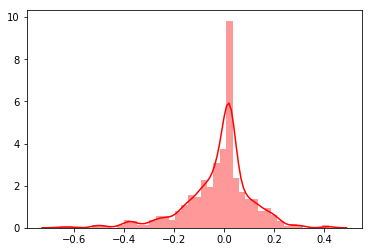

In [57]:
subreddit_Analysis(pd.read_csv('./Data/all10018.csv'), output_figname='TestingB')

### r/Democrats

In [24]:
subreddit_getter('Democrats', 'CBH_Bot', max_pulls=20)

    iteration 0 worked. URL: https://www.reddit.com/r/Democrats/.json?after=t3_9d2xrk
    iteration 1 worked. URL: https://www.reddit.com/r/Democrats/.json?after=t3_9cvdbw
    iteration 2 worked. URL: https://www.reddit.com/r/Democrats/.json?after=t3_9cs73c
    iteration 3 worked. URL: https://www.reddit.com/r/Democrats/.json?after=t3_9cpgoh
    iteration 4 worked. URL: https://www.reddit.com/r/Democrats/.json?after=t3_9chcgk
    iteration 5 worked. URL: https://www.reddit.com/r/Democrats/.json?after=t3_9cfujx
    iteration 6 worked. URL: https://www.reddit.com/r/Democrats/.json?after=t3_9c9p21
    iteration 7 worked. URL: https://www.reddit.com/r/Democrats/.json?after=t3_9c4rb2
    iteration 8 worked. URL: https://www.reddit.com/r/Democrats/.json?after=t3_9bygjo
    iteration 9 worked. URL: https://www.reddit.com/r/Democrats/.json?after=t3_9bpvpj
    iteration 10 worked. URL: https://www.reddit.com/r/Democrats/.json?after=t3_9bkpbc
    iteration 11 worked. URL: https://www.reddit.com/

   None Count:  81
   Rep Count:  7
   Dem Count:  413
   Adj Dem Count:  486
   Adj Rep Count:  15
   Percent Dem:  0.9700598802395209
   net score:  -471
   net sum of probas:  -200.50051019133326
   mean proba delta:  -0.40020061914437743
   mode:  ModeResult(mode=array([-0.51105909]), count=array([2]))
   med:  -0.4270739661767351


C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


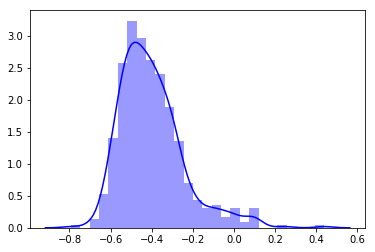

In [107]:
subreddit_Analysis(pd.read_csv('./Data/Democrats18076.csv'), output_figname='DemB')

### r/Republican

In [26]:
subreddit_getter('Republican', 'CBH_Bot', max_pulls=20)

    iteration 0 worked. URL: https://www.reddit.com/r/Republican/.json?after=t3_9cg4z7
    iteration 1 worked. URL: https://www.reddit.com/r/Republican/.json?after=t3_9bpt7f
    iteration 2 worked. URL: https://www.reddit.com/r/Republican/.json?after=t3_9b9ias
    iteration 3 worked. URL: https://www.reddit.com/r/Republican/.json?after=t3_9abkdq
    iteration 4 worked. URL: https://www.reddit.com/r/Republican/.json?after=t3_99x4pa
    iteration 5 worked. URL: https://www.reddit.com/r/Republican/.json?after=t3_99fdid
    iteration 6 worked. URL: https://www.reddit.com/r/Republican/.json?after=t3_98gnr6
    iteration 7 worked. URL: https://www.reddit.com/r/Republican/.json?after=t3_9807r3
    iteration 8 worked. URL: https://www.reddit.com/r/Republican/.json?after=t3_976j7b
    iteration 9 worked. URL: https://www.reddit.com/r/Republican/.json?after=t3_96l0ye
    iteration 10 worked. URL: https://www.reddit.com/r/Republican/.json?after=t3_95xwsh
    iteration 11 worked. URL: https://www.

   None Count:  94
   Rep Count:  389
   Dem Count:  17
   Adj Dem Count:  37
   Adj Rep Count:  463
   Percent Dem:  0.074
   net score:  426
   net sum of probas:  154.2265776283272
   mean proba delta:  0.3084531552566547
   mode:  ModeResult(mode=array([0.02375733]), count=array([2]))
   med:  0.35913189965155


C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


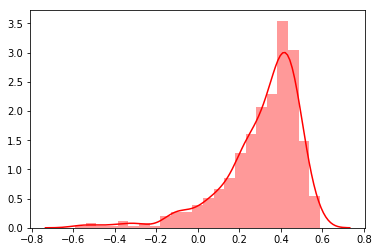

In [108]:
subreddit_Analysis(pd.read_csv('./Data/Republican58200.csv'), output_figname='RepB')

## Outside Testing: What does it look like on other subs?


### r/The_Donald


In [28]:
subreddit_getter('the_donald', 'CBH_Bot', max_pulls=20)

    iteration 0 worked. URL: https://www.reddit.com/r/the_donald/.json?after=t3_9d60lx
    iteration 1 worked. URL: https://www.reddit.com/r/the_donald/.json?after=t3_9d6s9f
    iteration 2 worked. URL: https://www.reddit.com/r/the_donald/.json?after=t3_9d6opz
    iteration 3 worked. URL: https://www.reddit.com/r/the_donald/.json?after=t3_9czjf5
    iteration 4 worked. URL: https://www.reddit.com/r/the_donald/.json?after=t3_9d5vzv
    iteration 5 worked. URL: https://www.reddit.com/r/the_donald/.json?after=t3_9d20v8
    iteration 6 worked. URL: https://www.reddit.com/r/the_donald/.json?after=t3_9d0yml
    iteration 7 worked. URL: https://www.reddit.com/r/the_donald/.json?after=t3_9cya26
    iteration 8 worked. URL: https://www.reddit.com/r/the_donald/.json?after=t3_9d2hsb
    iteration 9 worked. URL: https://www.reddit.com/r/the_donald/.json?after=t3_9d85gl
    iteration 10 worked. URL: https://www.reddit.com/r/the_donald/.json?after=t3_9d4tb4
    iteration 11 worked. URL: https://www.

   None Count:  349
   Rep Count:  35
   Dem Count:  118
   Adj Dem Count:  325
   Adj Rep Count:  177
   Percent Dem:  0.647410358565737
   net score:  -148
   net sum of probas:  -49.89094009821424
   mean proba delta:  -0.09938434282512809
   mode:  ModeResult(mode=array([0.02375733]), count=array([9]))
   med:  -0.06848336560493196


C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


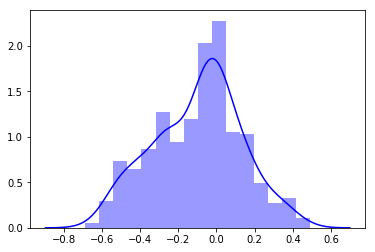

In [109]:
subreddit_Analysis(pd.read_csv('./Data/the_donald68589.csv'), output_figname='Donal_B')

### r/cats


In [30]:
subreddit_getter('cats', 'CBH_Bot', max_pulls=20)

    iteration 0 worked. URL: https://www.reddit.com/r/cats/.json?after=t3_9d7nol
    iteration 1 worked. URL: https://www.reddit.com/r/cats/.json?after=t3_9d2i4h
    iteration 2 worked. URL: https://www.reddit.com/r/cats/.json?after=t3_9d7vff
    iteration 3 worked. URL: https://www.reddit.com/r/cats/.json?after=t3_9d5sth
    iteration 4 worked. URL: https://www.reddit.com/r/cats/.json?after=t3_9d71w7
    iteration 5 worked. URL: https://www.reddit.com/r/cats/.json?after=t3_9cwpqn
    iteration 6 worked. URL: https://www.reddit.com/r/cats/.json?after=t3_9d2fxg
    iteration 7 worked. URL: https://www.reddit.com/r/cats/.json?after=t3_9d7aiu
    iteration 8 worked. URL: https://www.reddit.com/r/cats/.json?after=t3_9cwccm
    iteration 9 worked. URL: https://www.reddit.com/r/cats/.json?after=t3_9cy342
    iteration 10 worked. URL: https://www.reddit.com/r/cats/.json?after=t3_9d7ouw
    iteration 11 worked. URL: https://www.reddit.com/r/cats/.json?after=t3_9d2ak8
    iteration 12 worked. U

   None Count:  499
   Rep Count:  0
   Dem Count:  1
   Adj Dem Count:  308
   Adj Rep Count:  192
   Percent Dem:  0.616
   net score:  -116
   net sum of probas:  -18.916271425476573
   mean proba delta:  -0.037832542850953124
   mode:  ModeResult(mode=array([0.02375733]), count=array([18]))
   med:  -0.03142984837493046


C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


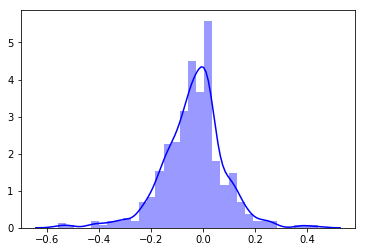

In [110]:
subreddit_Analysis(pd.read_csv('./Data/cats105.csv'), output_figname='the_cats_B')

### r/dogs


In [32]:
subreddit_getter('dogs', 'CBH_Bot', max_pulls=20)

    iteration 0 worked. URL: https://www.reddit.com/r/dogs/.json?after=t3_9cwr7h
    iteration 1 worked. URL: https://www.reddit.com/r/dogs/.json?after=t3_9czr7m
    iteration 2 worked. URL: https://www.reddit.com/r/dogs/.json?after=t3_9czbi7
    iteration 3 worked. URL: https://www.reddit.com/r/dogs/.json?after=t3_9cy1k9
    iteration 4 worked. URL: https://www.reddit.com/r/dogs/.json?after=t3_9cunrj
    iteration 5 worked. URL: https://www.reddit.com/r/dogs/.json?after=t3_9cs6eg
    iteration 6 worked. URL: https://www.reddit.com/r/dogs/.json?after=t3_9clca9
    iteration 7 worked. URL: https://www.reddit.com/r/dogs/.json?after=t3_9cji11
    iteration 8 worked. URL: https://www.reddit.com/r/dogs/.json?after=t3_9cjgho
    iteration 9 worked. URL: https://www.reddit.com/r/dogs/.json?after=t3_9cf68f
    iteration 10 worked. URL: https://www.reddit.com/r/dogs/.json?after=t3_9cb1cw
    iteration 11 worked. URL: https://www.reddit.com/r/dogs/.json?after=t3_9c98ki
    iteration 12 worked. U

   None Count:  502
   Rep Count:  0
   Dem Count:  0
   Adj Dem Count:  469
   Adj Rep Count:  33
   Percent Dem:  0.9342629482071713
   net score:  -436
   net sum of probas:  -68.18104161571574
   mean proba delta:  -0.1358188079994338
   mode:  ModeResult(mode=array([-0.66794204]), count=array([6]))
   med:  -0.10672822597389864


C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


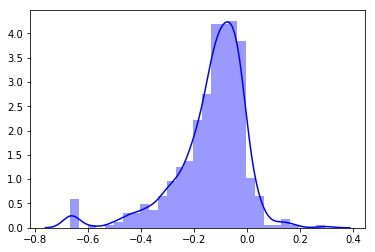

In [111]:
subreddit_Analysis(pd.read_csv('./Data/dogs48732.csv'), output_figname='dogs_B')

### r/Communism


In [34]:
subreddit_getter('Communism', 'CBH_Bot', max_pulls=20)

    iteration 0 worked. URL: https://www.reddit.com/r/Communism/.json?after=t3_9coax5
    iteration 1 worked. URL: https://www.reddit.com/r/Communism/.json?after=t3_9c7kvs
    iteration 2 worked. URL: https://www.reddit.com/r/Communism/.json?after=t3_9bo4cb
    iteration 3 worked. URL: https://www.reddit.com/r/Communism/.json?after=t3_9afr1p
    iteration 4 worked. URL: https://www.reddit.com/r/Communism/.json?after=t3_99tysz
    iteration 5 worked. URL: https://www.reddit.com/r/Communism/.json?after=t3_99csmx
    iteration 6 worked. URL: https://www.reddit.com/r/Communism/.json?after=t3_988bti
    iteration 7 worked. URL: https://www.reddit.com/r/Communism/.json?after=t3_9794fi
    iteration 8 worked. URL: https://www.reddit.com/r/Communism/.json?after=t3_96xuui
    iteration 9 worked. URL: https://www.reddit.com/r/Communism/.json?after=t3_9663jb
    iteration 10 worked. URL: https://www.reddit.com/r/Communism/.json?after=t3_95oicc
    iteration 11 worked. URL: https://www.reddit.com/

   None Count:  447
   Rep Count:  31
   Dem Count:  22
   Adj Dem Count:  220
   Adj Rep Count:  280
   Percent Dem:  0.44
   net score:  60
   net sum of probas:  7.534827011419643
   mean proba delta:  0.015069654022839279
   mode:  ModeResult(mode=array([0.02375733]), count=array([25]))
   med:  0.02357634387662233


C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


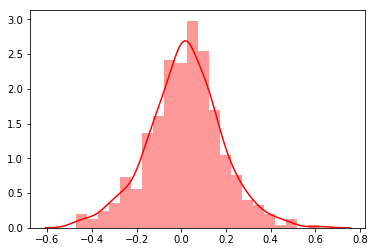

In [112]:
subreddit_Analysis(pd.read_csv('./Data/Communism91999.csv'), output_figname='commies_B')

### r/libertarian


In [36]:
subreddit_getter('Libertarian', 'CBH_Bot', max_pulls=20)

    iteration 0 worked. URL: https://www.reddit.com/r/Libertarian/.json?after=t3_9d5bj4
    iteration 1 worked. URL: https://www.reddit.com/r/Libertarian/.json?after=t3_9d81iw
    iteration 2 worked. URL: https://www.reddit.com/r/Libertarian/.json?after=t3_9d6e8c
    iteration 3 worked. URL: https://www.reddit.com/r/Libertarian/.json?after=t3_9d79c2
    iteration 4 worked. URL: https://www.reddit.com/r/Libertarian/.json?after=t3_9d79n5
    iteration 5 worked. URL: https://www.reddit.com/r/Libertarian/.json?after=t3_9d0o5n
    iteration 6 worked. URL: https://www.reddit.com/r/Libertarian/.json?after=t3_9d0nwc
    iteration 7 worked. URL: https://www.reddit.com/r/Libertarian/.json?after=t3_9cwt6z
    iteration 8 worked. URL: https://www.reddit.com/r/Libertarian/.json?after=t3_9cmrs3
    iteration 9 worked. URL: https://www.reddit.com/r/Libertarian/.json?after=t3_9cwbdj
    iteration 10 worked. URL: https://www.reddit.com/r/Libertarian/.json?after=t3_9cs0lo
    iteration 11 worked. URL: h

   None Count:  413
   Rep Count:  29
   Dem Count:  60
   Adj Dem Count:  250
   Adj Rep Count:  252
   Percent Dem:  0.49800796812749004
   net score:  2
   net sum of probas:  -12.46710763603424
   mean proba delta:  -0.024834875768992504
   mode:  ModeResult(mode=array([0.02375733]), count=array([22]))
   med:  0.0009549565880969391


C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


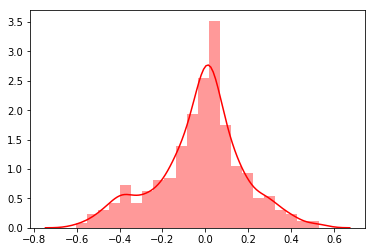

In [113]:
subreddit_Analysis(pd.read_csv('./Data/Libertarian41804.csv'), output_figname='libertarian_B')

### r/Liberal


In [38]:
subreddit_getter('Liberal', 'CBH_Bot', max_pulls=20)

    iteration 0 worked. URL: https://www.reddit.com/r/Liberal/.json?after=t3_9cl4w3
    iteration 1 worked. URL: https://www.reddit.com/r/Liberal/.json?after=t3_9bgf1k
    iteration 2 worked. URL: https://www.reddit.com/r/Liberal/.json?after=t3_9a92pl
    iteration 3 worked. URL: https://www.reddit.com/r/Liberal/.json?after=t3_9971lr
    iteration 4 worked. URL: https://www.reddit.com/r/Liberal/.json?after=t3_98lehf
    iteration 5 worked. URL: https://www.reddit.com/r/Liberal/.json?after=t3_97bek2
    iteration 6 worked. URL: https://www.reddit.com/r/Liberal/.json?after=t3_965q5m
    iteration 7 worked. URL: https://www.reddit.com/r/Liberal/.json?after=t3_950y06
    iteration 8 worked. URL: https://www.reddit.com/r/Liberal/.json?after=t3_944arl
    iteration 9 worked. URL: https://www.reddit.com/r/Liberal/.json?after=t3_93kkts
    iteration 10 worked. URL: https://www.reddit.com/r/Liberal/.json?after=t3_92d5ac
    iteration 11 worked. URL: https://www.reddit.com/r/Liberal/.json?after=

   None Count:  218
   Rep Count:  56
   Dem Count:  226
   Adj Dem Count:  347
   Adj Rep Count:  153
   Percent Dem:  0.694
   net score:  -194
   net sum of probas:  -64.9970433491518
   mean proba delta:  -0.12999408669830356
   mode:  ModeResult(mode=array([0.02375733]), count=array([2]))
   med:  -0.11938581314633856


C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


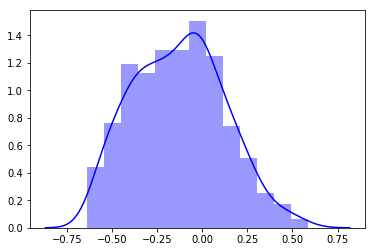

In [114]:
subreddit_Analysis(pd.read_csv('./Data/Liberal35849.csv'), output_figname='liberal_B')

### r/GameofThrones


In [41]:
subreddit_getter('gameofthrones', 'CBH_Bot', max_pulls=20)

    iteration 0 worked. URL: https://www.reddit.com/r/gameofthrones/.json?after=t3_9cwtq2
    iteration 1 worked. URL: https://www.reddit.com/r/gameofthrones/.json?after=t3_9cl8tj
    iteration 2 worked. URL: https://www.reddit.com/r/gameofthrones/.json?after=t3_9ck662
    iteration 3 worked. URL: https://www.reddit.com/r/gameofthrones/.json?after=t3_9ce8b0
    iteration 4 worked. URL: https://www.reddit.com/r/gameofthrones/.json?after=t3_9c0lca
    iteration 5 worked. URL: https://www.reddit.com/r/gameofthrones/.json?after=t3_9bje1t
    iteration 6 worked. URL: https://www.reddit.com/r/gameofthrones/.json?after=t3_9b9xmn
    iteration 7 worked. URL: https://www.reddit.com/r/gameofthrones/.json?after=t3_9aycuc
    iteration 8 worked. URL: https://www.reddit.com/r/gameofthrones/.json?after=t3_9aig5w
    iteration 9 worked. URL: https://www.reddit.com/r/gameofthrones/.json?after=t3_9aejp8
    iteration 10 worked. URL: https://www.reddit.com/r/gameofthrones/.json?after=t3_9a6h88
    itera

   None Count:  502
   Rep Count:  0
   Dem Count:  0
   Adj Dem Count:  258
   Adj Rep Count:  244
   Percent Dem:  0.5139442231075697
   net score:  -14
   net sum of probas:  -6.9192638469295655
   mean proba delta:  -0.01378339411738955
   mode:  ModeResult(mode=array([0.01986896]), count=array([39]))
   med:  -0.0021319638668767515


C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


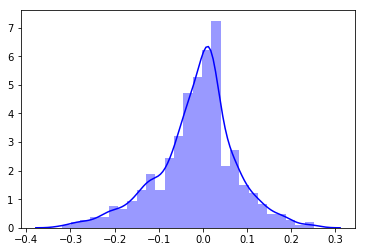

In [115]:
subreddit_Analysis(pd.read_csv('./Data/gameofthrones38795.csv'), output_figname='GOT_B')

### r/asoiaf


In [45]:
subreddit_getter('asoiaf', 'CBH_Bot', max_pulls=20)

    iteration 0 worked. URL: https://www.reddit.com/r/asoiaf/.json?after=t3_9cvz46
    iteration 1 worked. URL: https://www.reddit.com/r/asoiaf/.json?after=t3_9cb8w9
    iteration 2 worked. URL: https://www.reddit.com/r/asoiaf/.json?after=t3_9c3kno
    iteration 3 worked. URL: https://www.reddit.com/r/asoiaf/.json?after=t3_9bzvee
    iteration 4 worked. URL: https://www.reddit.com/r/asoiaf/.json?after=t3_9bcc40
    iteration 5 worked. URL: https://www.reddit.com/r/asoiaf/.json?after=t3_9bbee5
    iteration 6 worked. URL: https://www.reddit.com/r/asoiaf/.json?after=t3_9azduy
    iteration 7 worked. URL: https://www.reddit.com/r/asoiaf/.json?after=t3_9ai7vx
    iteration 8 worked. URL: https://www.reddit.com/r/asoiaf/.json?after=t3_9amyj2
    iteration 9 worked. URL: https://www.reddit.com/r/asoiaf/.json?after=t3_9a46xy
    iteration 10 worked. URL: https://www.reddit.com/r/asoiaf/.json?after=t3_99w5wh
    iteration 11 worked. URL: https://www.reddit.com/r/asoiaf/.json?after=t3_99v69p
  

   None Count:  501
   Rep Count:  0
   Dem Count:  1
   Adj Dem Count:  231
   Adj Rep Count:  271
   Percent Dem:  0.4601593625498008
   net score:  40
   net sum of probas:  -3.5265172880089235
   mean proba delta:  -0.007024934836671172
   mode:  ModeResult(mode=array([0.01986896]), count=array([75]))
   med:  0.010986715408784126


C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


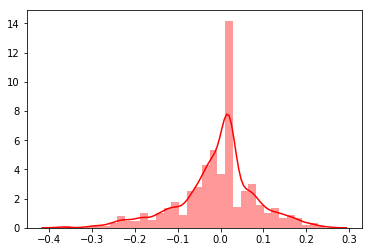

In [116]:
subreddit_Analysis(pd.read_csv('./Data/asoiaf36417.csv'), output_figname='ASOIAF_B')

### r/NFL


In [47]:
subreddit_getter('nfl', 'CBH_Bot', max_pulls=20)

    iteration 0 worked. URL: https://www.reddit.com/r/nfl/.json?after=t3_9cz75f
    iteration 1 worked. URL: https://www.reddit.com/r/nfl/.json?after=t3_9d7nnc
    iteration 2 worked. URL: https://www.reddit.com/r/nfl/.json?after=t3_9czbln
    iteration 3 worked. URL: https://www.reddit.com/r/nfl/.json?after=t3_9cvq44
    iteration 4 worked. URL: https://www.reddit.com/r/nfl/.json?after=t3_9cxqsa
    iteration 5 worked. URL: https://www.reddit.com/r/nfl/.json?after=t3_9cs7mx
    iteration 6 worked. URL: https://www.reddit.com/r/nfl/.json?after=t3_9cp32m
    iteration 7 worked. URL: https://www.reddit.com/r/nfl/.json?after=t3_9cnfh9
    iteration 8 worked. URL: https://www.reddit.com/r/nfl/.json?after=t3_9cwicv
    iteration 9 worked. URL: https://www.reddit.com/r/nfl/.json?after=t3_9cp4uq
    iteration 10 worked. URL: https://www.reddit.com/r/nfl/.json?after=t3_9coeqv
    iteration 11 worked. URL: https://www.reddit.com/r/nfl/.json?after=t3_9d00mo
    iteration 12 worked. URL: https://

   None Count:  495
   Rep Count:  3
   Dem Count:  4
   Adj Dem Count:  295
   Adj Rep Count:  207
   Percent Dem:  0.5876494023904383
   net score:  -88
   net sum of probas:  -21.50032546015844
   mean proba delta:  -0.04282933358597298
   mode:  ModeResult(mode=array([0.02375733]), count=array([7]))
   med:  -0.030800617746654768


C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


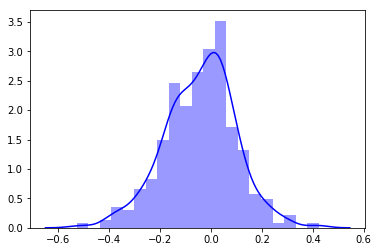

In [117]:
subreddit_Analysis(pd.read_csv('./Data/nfl69766.csv'), output_figname='NFL_B')

### r/CFB


In [49]:
subreddit_getter('CFB', 'CBH_Bot', max_pulls=20)

    iteration 0 worked. URL: https://www.reddit.com/r/CFB/.json?after=t3_9d830v
    iteration 1 worked. URL: https://www.reddit.com/r/CFB/.json?after=t3_9d8d5d
    iteration 2 worked. URL: https://www.reddit.com/r/CFB/.json?after=t3_9d2kig
    iteration 3 worked. URL: https://www.reddit.com/r/CFB/.json?after=t3_9ct52k
    iteration 4 worked. URL: https://www.reddit.com/r/CFB/.json?after=t3_9d0mxq
    iteration 5 worked. URL: https://www.reddit.com/r/CFB/.json?after=t3_9cxf9g
    iteration 6 worked. URL: https://www.reddit.com/r/CFB/.json?after=t3_9corp5
    iteration 7 worked. URL: https://www.reddit.com/r/CFB/.json?after=t3_9cp7tl
    iteration 8 worked. URL: https://www.reddit.com/r/CFB/.json?after=t3_9chgca
    iteration 9 worked. URL: https://www.reddit.com/r/CFB/.json?after=t3_9cgdyp
    iteration 10 worked. URL: https://www.reddit.com/r/CFB/.json?after=t3_9c7nka
    iteration 11 worked. URL: https://www.reddit.com/r/CFB/.json?after=t3_9ccsju
    iteration 12 worked. URL: https://

   None Count:  490
   Rep Count:  7
   Dem Count:  5
   Adj Dem Count:  174
   Adj Rep Count:  328
   Percent Dem:  0.3466135458167331
   net score:  154
   net sum of probas:  21.17886469210252
   mean proba delta:  0.04218897349024404
   mode:  ModeResult(mode=array([0.17290888]), count=array([10]))
   med:  0.039129664805272885


C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


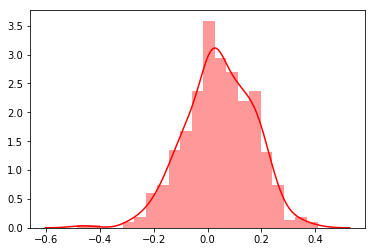

In [118]:
subreddit_Analysis(pd.read_csv('./Data/CFB14986.csv'), output_figname='CFB_B')

### r/soccer


In [51]:
subreddit_getter('soccer', 'CBH_Bot', max_pulls=20)

    iteration 0 worked. URL: https://www.reddit.com/r/soccer/.json?after=t3_9d0h1n
    iteration 1 worked. URL: https://www.reddit.com/r/soccer/.json?after=t3_9d4vjc
    iteration 2 worked. URL: https://www.reddit.com/r/soccer/.json?after=t3_9cvg80
    iteration 3 worked. URL: https://www.reddit.com/r/soccer/.json?after=t3_9d3i4v
    iteration 4 worked. URL: https://www.reddit.com/r/soccer/.json?after=t3_9cv0e3
    iteration 5 worked. URL: https://www.reddit.com/r/soccer/.json?after=t3_9ctpxy
    iteration 6 worked. URL: https://www.reddit.com/r/soccer/.json?after=t3_9cu9ry
    iteration 7 worked. URL: https://www.reddit.com/r/soccer/.json?after=t3_9cxid1
    iteration 8 worked. URL: https://www.reddit.com/r/soccer/.json?after=t3_9cv451
    iteration 9 worked. URL: https://www.reddit.com/r/soccer/.json?after=t3_9ckunr
    iteration 10 worked. URL: https://www.reddit.com/r/soccer/.json?after=t3_9cu0nv
    iteration 11 worked. URL: https://www.reddit.com/r/soccer/.json?after=t3_9cnkdr
  

   None Count:  494
   Rep Count:  2
   Dem Count:  6
   Adj Dem Count:  259
   Adj Rep Count:  243
   Percent Dem:  0.5159362549800797
   net score:  -16
   net sum of probas:  -8.287825349824853
   mean proba delta:  -0.01650961225064712
   mode:  ModeResult(mode=array([0.02375733]), count=array([16]))
   med:  -0.007456858541753375


C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


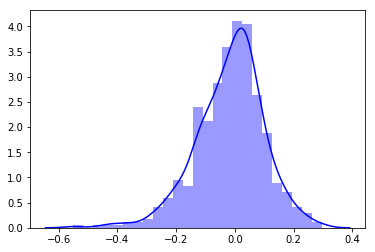

In [119]:
subreddit_Analysis(pd.read_csv('./Data/soccer30540.csv'), output_figname='soccer_B')

### r/malefashionadvice

In [102]:
subreddit_getter('malefashionadvice', 'CBH_Bot', max_pulls=20)

    iteration 0 worked. URL: https://www.reddit.com/r/malefashionadvice/.json?after=t3_9cqqjo
    iteration 1 worked. URL: https://www.reddit.com/r/malefashionadvice/.json?after=t3_9cd5t5
    iteration 2 worked. URL: https://www.reddit.com/r/malefashionadvice/.json?after=t3_9buw4s
    iteration 3 worked. URL: https://www.reddit.com/r/malefashionadvice/.json?after=t3_9ba7nu
    iteration 4 worked. URL: https://www.reddit.com/r/malefashionadvice/.json?after=t3_9at8qq
    iteration 5 worked. URL: https://www.reddit.com/r/malefashionadvice/.json?after=t3_9a7vtq
    iteration 6 worked. URL: https://www.reddit.com/r/malefashionadvice/.json?after=t3_99onog
    iteration 7 worked. URL: https://www.reddit.com/r/malefashionadvice/.json?after=t3_999c81
    text file:  malefashionadvice23143
    size:  (218, 2)


   None Count:  216
   Rep Count:  0
   Dem Count:  2
   Adj Dem Count:  145
   Adj Rep Count:  73
   Percent Dem:  0.6651376146788991
   net score:  -72
   net sum of probas:  -14.43928067956762
   mean proba delta:  -0.0662352324750808
   mode:  ModeResult(mode=array([0.02375733]), count=array([5]))
   med:  -0.05683604485826965


C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


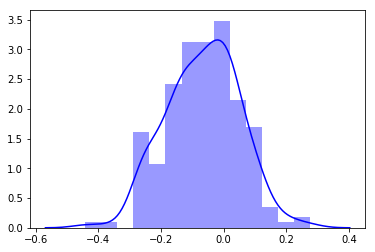

In [120]:
subreddit_Analysis(df_latest_scrape, output_figname='MFA_B')

0.032074794542322066